# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.1.0+cu118


'cpu'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Increase the model complexity. Add more hidden layers, or more activation functions.
2. Add more features or transfrom them.
3. Reduce regularization. If you used L1 and L2 regularization in over to prevent overfitting maybe you over did it.
4. Increase the numer of Epochs.
5. Tune the hyper paramtets in your model.
6. Corss validate to see if the problem is happening because of a specific parf of data.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "custom_dataset"

if image_path.is_dir():
  print(f"{image_path} is a directory")
else:
  print(f"Making a directory")
  image_path.mkdir(parents=True, exist_ok=True) # parent=true will make paretn dir if needed

with open(data_path / "custom_dataset.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading... ")
  f.write(request.content) # write the request into the f(ile)

with zipfile.ZipFile(data_path/"custom_dataset.zip", "r") as zip_ref:
  zip_ref.extractall(image_path)

data/custom_dataset is a directory
Downloading... 


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path/ "test"

train_dir, test_dir

(PosixPath('data/custom_dataset/train'), PosixPath('data/custom_dataset/test'))

image path: data/custom_dataset/test/sushi/2385731.jpg
image class: sushi
image width: 512
image heigth: 512


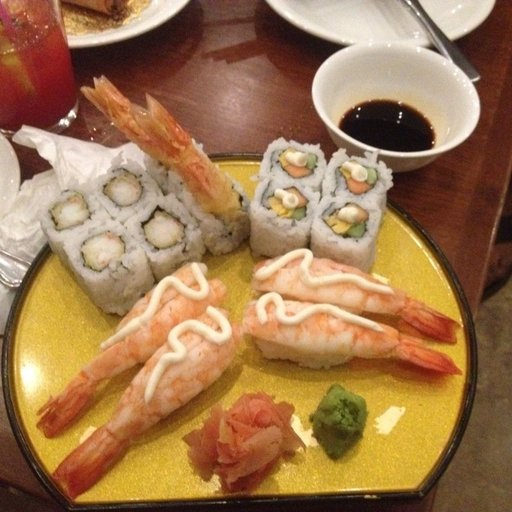

In [6]:
# Visualize an image
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem # prints */[*]/* --> train/pizza/120934.jpg

img = Image.open(random_image_path)

print(f"image path: {random_image_path}")
print(f"image class: {image_class}")
print(f"image width: {img.width}")
print(f"image heigth: {img.height}")
img

(-0.5, 511.5, 511.5, -0.5)

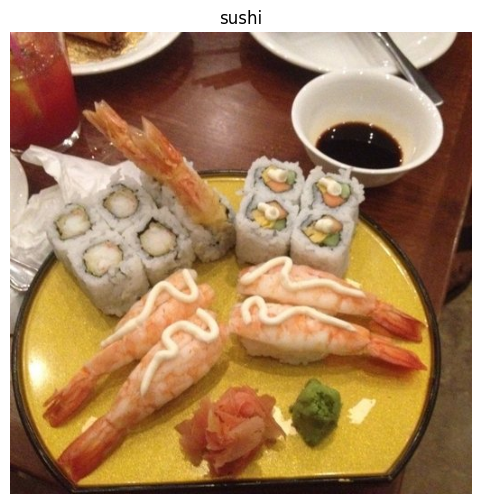

In [7]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

image_plot = np.asarray(img) # matplotlib like np

plt.figure(figsize=(6,6))
plt.imshow(image_plot)
plt.title(image_class)
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [8]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [9]:
# Write transform for turning images into tensors
tran = transforms.Compose(
    [
        transforms.Resize(size=(64,64)),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor() # has to be last
    ]
)

In [10]:
# Write a function to plot transformed images
def plot_tran_img(image_path, transform, n=3):
  random_image_paths = random.sample(image_path, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\n Size: {f.size}")

      transfomred_img = transform(f).permute(2,1,0)

      ax[1].imshow(    transfomred_img)
      ax[1].set_title(f"Transformed\n Size: {transfomred_img.shape}")

      fig.suptitle(f" Class: {image_path.parent.stem}", fontsize = 12)

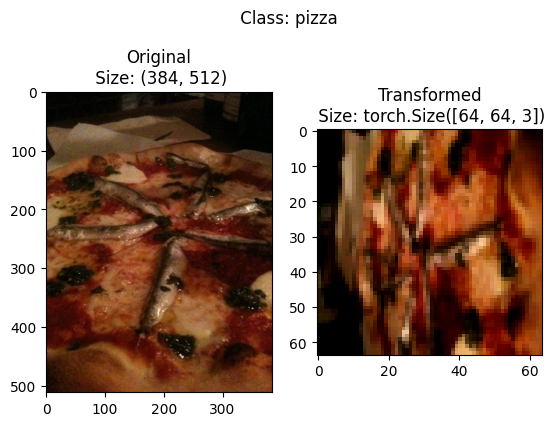

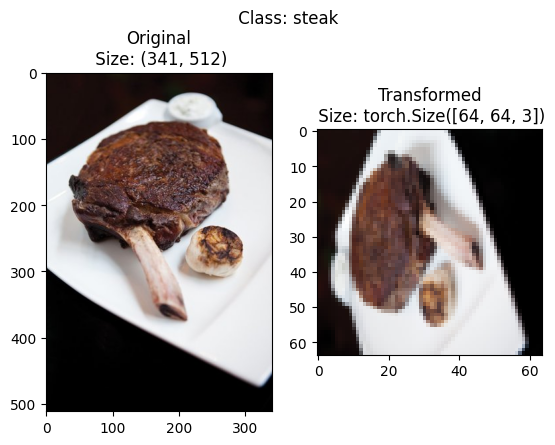

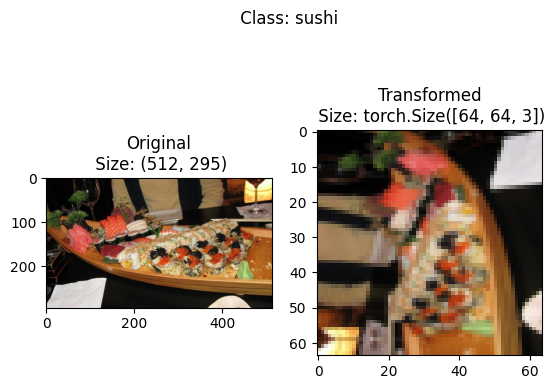

In [11]:
plot_tran_img(image_path_list,
              transform = tran,
              n=3)

### Load image data using `ImageFolder`

In [12]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=tran,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=tran,
    target_transform=None
)

In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [16]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)


In [17]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(29, 10)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [18]:
from torch import nn
class TinyVGG(nn.Module):
  def __init__(self,
               input: int,
               output: int,
               hidden: int):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input,
                  out_channels=hidden,
                  kernel_size=(3,3),
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden,
                  out_channels=hidden,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d((2,2))
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden,
                  out_channels=hidden,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden,
                  out_channels=hidden,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d((2,2))
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden*13*13,
                  out_features=output)
    )

  def forward(self, x):
    return self.classifier(self.conv_block2(self.conv_block1(x)))

In [19]:
model0 = TinyVGG(input = 3,
                 output = 3,
                 hidden = 10)
model0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [20]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [21]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      test_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [22]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [23]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model0.parameters(),
                             lr=0.001)

train(model0,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1084 | train_acc: 0.3190 | test_loss: 1.1154 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.1021 | train_acc: 0.3664 | test_loss: 1.1036 | test_acc: 0.3125
Epoch: 3 | train_loss: 1.1015 | train_acc: 0.3664 | test_loss: 1.1072 | test_acc: 0.3125
Epoch: 4 | train_loss: 1.0976 | train_acc: 0.3362 | test_loss: 1.1060 | test_acc: 0.3125
Epoch: 5 | train_loss: 1.0890 | train_acc: 0.3750 | test_loss: 1.0947 | test_acc: 0.3000


{'train_loss': [1.1084054132987713,
  1.102060264554517,
  1.101540779245311,
  1.0975551194158093,
  1.0890231420253884],
 'train_acc': [0.31896551724137934,
  0.36637931034482757,
  0.36637931034482757,
  0.33620689655172414,
  0.375],
 'test_loss': [1.1153711438179017,
  1.1035911440849304,
  1.1071733355522155,
  1.106042754650116,
  1.0947427153587341],
 'test_acc': [0.3125, 0.3125, 0.3125, 0.3125, 0.3]}

In [24]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model0.parameters(),
                             lr=0.001)

train(model0,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0904 | train_acc: 0.3750 | test_loss: 1.0798 | test_acc: 0.3250
Epoch: 2 | train_loss: 1.0592 | train_acc: 0.4181 | test_loss: 1.0626 | test_acc: 0.3500
Epoch: 3 | train_loss: 1.0324 | train_acc: 0.4310 | test_loss: 1.0848 | test_acc: 0.3375
Epoch: 4 | train_loss: 1.0105 | train_acc: 0.4526 | test_loss: 1.0677 | test_acc: 0.3250
Epoch: 5 | train_loss: 0.9239 | train_acc: 0.5733 | test_loss: 1.1020 | test_acc: 0.4000
Epoch: 6 | train_loss: 0.9631 | train_acc: 0.5474 | test_loss: 1.1191 | test_acc: 0.3708
Epoch: 7 | train_loss: 1.0067 | train_acc: 0.5129 | test_loss: 1.0650 | test_acc: 0.4250
Epoch: 8 | train_loss: 0.9914 | train_acc: 0.5086 | test_loss: 1.0420 | test_acc: 0.4583
Epoch: 9 | train_loss: 0.9925 | train_acc: 0.4957 | test_loss: 1.0288 | test_acc: 0.3708
Epoch: 10 | train_loss: 0.9055 | train_acc: 0.5517 | test_loss: 1.0676 | test_acc: 0.3625
Epoch: 11 | train_loss: 0.9463 | train_acc: 0.5388 | test_loss: 1.0751 | test_acc: 0.4208
Epoch: 12 | train_l

{'train_loss': [1.090448391848597,
  1.059176305244709,
  1.0324315099880612,
  1.0105492554861923,
  0.9238692686475557,
  0.96305578741534,
  1.0066552141617084,
  0.9913567263504555,
  0.992479230823188,
  0.9054587976685886,
  0.94634184755128,
  0.9094947576522827,
  0.9275856449686247,
  0.9202127333345085,
  0.9195294256868034,
  0.9285149389299853,
  0.8812799309862072,
  0.8848454191766936,
  0.8417743578039366,
  0.8641875252641481],
 'train_acc': [0.375,
  0.41810344827586204,
  0.43103448275862066,
  0.4525862068965517,
  0.5732758620689655,
  0.5474137931034483,
  0.5129310344827587,
  0.5086206896551724,
  0.4956896551724138,
  0.5517241379310345,
  0.5387931034482759,
  0.5818965517241379,
  0.5646551724137931,
  0.5646551724137931,
  0.5646551724137931,
  0.5818965517241379,
  0.5775862068965517,
  0.5560344827586207,
  0.5991379310344828,
  0.6293103448275862],
 'test_loss': [1.0797500491142273,
  1.0626277148723602,
  1.0848295271396637,
  1.0677027225494384,
  1.1020

In [25]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model0.parameters(),
                             lr=0.001)

train(model0,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8825 | train_acc: 0.6078 | test_loss: 1.0683 | test_acc: 0.4208
Epoch: 2 | train_loss: 0.8456 | train_acc: 0.6293 | test_loss: 0.9781 | test_acc: 0.4875
Epoch: 3 | train_loss: 0.8660 | train_acc: 0.6121 | test_loss: 1.0376 | test_acc: 0.4625
Epoch: 4 | train_loss: 0.7810 | train_acc: 0.6379 | test_loss: 1.1124 | test_acc: 0.4500
Epoch: 5 | train_loss: 0.7780 | train_acc: 0.6509 | test_loss: 1.1497 | test_acc: 0.4333
Epoch: 6 | train_loss: 0.8461 | train_acc: 0.5948 | test_loss: 1.0716 | test_acc: 0.4583
Epoch: 7 | train_loss: 0.9218 | train_acc: 0.5647 | test_loss: 1.0488 | test_acc: 0.4375
Epoch: 8 | train_loss: 0.8874 | train_acc: 0.5647 | test_loss: 1.0428 | test_acc: 0.5208
Epoch: 9 | train_loss: 0.8353 | train_acc: 0.6422 | test_loss: 1.0153 | test_acc: 0.4250
Epoch: 10 | train_loss: 0.7796 | train_acc: 0.6422 | test_loss: 1.0967 | test_acc: 0.4167
Epoch: 11 | train_loss: 0.8023 | train_acc: 0.5819 | test_loss: 1.0929 | test_acc: 0.4667
Epoch: 12 | train_l

{'train_loss': [0.882473651705117,
  0.8455907322209457,
  0.8660071307215197,
  0.7809879605112404,
  0.7780024542890746,
  0.8460555292409042,
  0.9218215074004799,
  0.8874246971360569,
  0.835258104677858,
  0.7795922386235205,
  0.8022863494938818,
  0.7713034820967707,
  0.8172713497589374,
  0.8369002732737311,
  0.8053934491913894,
  0.8197487664633784,
  0.7917398985089927,
  0.73277940935102,
  0.7242576857579166,
  0.7487439811229706,
  0.7052808265233862,
  0.7283625314975607,
  0.7744962102894125,
  0.7354664468559725,
  0.7489654853426176,
  0.7337076684524273,
  0.7299409339140202,
  0.7095006858480388,
  0.853690163842563,
  0.7810873450904057,
  0.708329350270074,
  0.6625970807568781,
  0.7178948840190624,
  0.7235392496503633,
  0.7075998577578314,
  0.7162051755806496,
  0.7092957578856369,
  0.6682741477571684,
  0.6813503729886022,
  0.810418526674139,
  0.6519412809404833,
  0.7196258738123137,
  0.7060144070921273,
  0.5741142476427143,
  0.6730742696030386,
  0

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [26]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model1 = TinyVGG(input=3,
                 output=3,
                 hidden=20)

train(model1,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0983 | train_acc: 0.3534 | test_loss: 1.1034 | test_acc: 0.2375
Epoch: 2 | train_loss: 1.0996 | train_acc: 0.3233 | test_loss: 1.1031 | test_acc: 0.2375
Epoch: 3 | train_loss: 1.0997 | train_acc: 0.3233 | test_loss: 1.1030 | test_acc: 0.2375
Epoch: 4 | train_loss: 1.0982 | train_acc: 0.3534 | test_loss: 1.1029 | test_acc: 0.2375
Epoch: 5 | train_loss: 1.0983 | train_acc: 0.3534 | test_loss: 1.1033 | test_acc: 0.2375
Epoch: 6 | train_loss: 1.0983 | train_acc: 0.3534 | test_loss: 1.1031 | test_acc: 0.2375
Epoch: 7 | train_loss: 1.0997 | train_acc: 0.3233 | test_loss: 1.1032 | test_acc: 0.2375
Epoch: 8 | train_loss: 1.0983 | train_acc: 0.3534 | test_loss: 1.1032 | test_acc: 0.2375
Epoch: 9 | train_loss: 1.0998 | train_acc: 0.3233 | test_loss: 1.1032 | test_acc: 0.2375
Epoch: 10 | train_loss: 1.0994 | train_acc: 0.3233 | test_loss: 1.1030 | test_acc: 0.2375
Epoch: 11 | train_loss: 1.0994 | train_acc: 0.3233 | test_loss: 1.1030 | test_acc: 0.2375
Epoch: 12 | train_l

{'train_loss': [1.0983390890318772,
  1.0995914072825992,
  1.0996683219383503,
  1.0981799076343406,
  1.0982647024351975,
  1.0982608055246288,
  1.099702210261904,
  1.0983415759842972,
  1.0997646471549725,
  1.0993563306742702,
  1.0993646095538963,
  1.099651340780587,
  1.0996915883031384,
  1.099843222519447,
  1.0997228170263356,
  1.0996440813459198,
  1.0984559799062794,
  1.0993901244525253,
  1.0995280454898704,
  1.0983308964762195],
 'train_acc': [0.35344827586206895,
  0.3232758620689655,
  0.3232758620689655,
  0.35344827586206895,
  0.35344827586206895,
  0.35344827586206895,
  0.3232758620689655,
  0.35344827586206895,
  0.3232758620689655,
  0.3232758620689655,
  0.3232758620689655,
  0.3232758620689655,
  0.3232758620689655,
  0.3232758620689655,
  0.3232758620689655,
  0.3232758620689655,
  0.35344827586206895,
  0.3232758620689655,
  0.3232758620689655,
  0.35344827586206895],
 'test_loss': [1.103354775905609,
  1.103119170665741,
  1.103049886226654,
  1.1029222

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [32]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [33]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.


Excellent, we now have double the training and testing images...

In [29]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [37]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data = datasets.ImageFolder(root=train_data_20_percent_path,
                                  transform=simple_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_data_20_percent_path,
                                 transform=simple_transform,
                                 target_transform=None)

# Create dataloaders
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = 8,
                              shuffle=True,
                              num_workers = 2)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = 8,
                             shuffle = True,
                             num_workers = 2)


In [38]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model2=TinyVGG(input = 3,
               output = 3,
               hidden = 10)

train(model=model2,
      train_dataloader=train_dataloader,
      test_dataloader = test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0978 | train_acc: 0.3377 | test_loss: 1.0990 | test_acc: 0.3092
Epoch: 2 | train_loss: 1.0977 | train_acc: 0.3443 | test_loss: 1.0990 | test_acc: 0.3026
Epoch: 3 | train_loss: 1.0977 | train_acc: 0.3443 | test_loss: 1.0991 | test_acc: 0.3048
Epoch: 4 | train_loss: 1.0977 | train_acc: 0.3443 | test_loss: 1.0989 | test_acc: 0.3092
Epoch: 5 | train_loss: 1.0979 | train_acc: 0.3377 | test_loss: 1.0990 | test_acc: 0.3070
Epoch: 6 | train_loss: 1.0977 | train_acc: 0.3443 | test_loss: 1.0990 | test_acc: 0.3092
Epoch: 7 | train_loss: 1.0978 | train_acc: 0.3377 | test_loss: 1.0990 | test_acc: 0.3026
Epoch: 8 | train_loss: 1.0978 | train_acc: 0.3377 | test_loss: 1.0990 | test_acc: 0.3048
Epoch: 9 | train_loss: 1.0977 | train_acc: 0.3443 | test_loss: 1.0990 | test_acc: 0.3070
Epoch: 10 | train_loss: 1.0977 | train_acc: 0.3443 | test_loss: 1.0990 | test_acc: 0.3048
Epoch: 11 | train_loss: 1.0976 | train_acc: 0.3509 | test_loss: 1.0990 | test_acc: 0.3092
Epoch: 12 | train_l

{'train_loss': [1.0978285994446069,
  1.097739389068202,
  1.097653485181039,
  1.0976793891505192,
  1.0978763417193764,
  1.097679196742543,
  1.0978193115769772,
  1.0977791213152701,
  1.097708444846304,
  1.0976674347593074,
  1.0975863285232008,
  1.0978970527648926,
  1.0975902749781024,
  1.0977339639998318,
  1.0976496286559523,
  1.0977473028919154,
  1.0976537884327404,
  1.0977365594161184,
  1.0977256799999036,
  1.0976548717733015],
 'train_acc': [0.33771929824561403,
  0.3442982456140351,
  0.3442982456140351,
  0.3442982456140351,
  0.33771929824561403,
  0.3442982456140351,
  0.33771929824561403,
  0.33771929824561403,
  0.3442982456140351,
  0.3442982456140351,
  0.3508771929824561,
  0.33771929824561403,
  0.3508771929824561,
  0.3442982456140351,
  0.3442982456140351,
  0.33771929824561403,
  0.3442982456140351,
  0.3442982456140351,
  0.3442982456140351,
  0.3442982456140351],
 'test_loss': [1.0989651303542287,
  1.0990159950758283,
  1.0990592241287231,
  1.098938